In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as plt

## 1. Cargar datos

In [3]:
data_full = pd.read_csv("time_series_15min_singleindex.csv")
data = data_full[['utc_timestamp','AT_load_actual_entsoe_transparency']].copy()
data.head()

,utc_timestamp,AT_load_actual_entsoe_transparency
0,2014-12-31T23:00:00Z,NaN
1,2014-12-31T23:15:00Z,NaN
2,2014-12-31T23:30:00Z,NaN
3,2014-12-31T23:45:00Z,NaN
4,2015-01-01T00:00:00Z,NaN


1.1. Formato correcto

In [4]:
data[['utc_timestamp']] = data[['utc_timestamp']].apply(pd.to_datetime)
data['local_timestamp'] = data['utc_timestamp'].dt.tz_convert('Europe/Vienna')
data.head()

,utc_timestamp,AT_load_actual_entsoe_transparency,local_timestamp
0,2014-12-31 23:00:00+00:00,NaN,2015-01-01 00:00:00+01:00
1,2014-12-31 23:15:00+00:00,NaN,2015-01-01 00:15:00+01:00
2,2014-12-31 23:30:00+00:00,NaN,2015-01-01 00:30:00+01:00
3,2014-12-31 23:45:00+00:00,NaN,2015-01-01 00:45:00+01:00
4,2015-01-01 00:00:00+00:00,NaN,2015-01-01 01:00:00+01:00


1.2. Quitar datos nulos

In [5]:
data = data.dropna()

## 2. Análisis de datos

In [6]:
data

,utc_timestamp,AT_load_actual_entsoe_transparency,local_timestamp
5,2015-01-01 00:15:00+00:00,5966.8,2015-01-01 01:15:00+01:00
6,2015-01-01 00:30:00+00:00,5935.6,2015-01-01 01:30:00+01:00
7,2015-01-01 00:45:00+00:00,5934.4,2015-01-01 01:45:00+01:00
8,2015-01-01 01:00:00+00:00,5750.8,2015-01-01 02:00:00+01:00
9,2015-01-01 01:15:00+00:00,5777.6,2015-01-01 02:15:00+01:00
...,...,...,...
201598,2020-09-30 22:30:00+00:00,5577.2,2020-10-01 00:30:00+02:00
201599,2020-09-30 22:45:00+00:00,5482.4,2020-10-01 00:45:00+02:00
201600,2020-09-30 23:00:00+00:00,5464.0,2020-10-01 01:00:00+02:00
201601,2020-09-30 23:15:00+00:00,5390.4,2020-10-01 01:15:00+02:00


## 3. Modelo

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import rpy2.robjects as robjects
import statsmodels.api as sm
from statsmodels.formula.api import ols
from astsadata import *
import warnings

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


### Funciones de soporte para graficar funciones de autocorrelación

In [8]:
def acf1(x, nlags=None, acf_type="correlation", pacf=False, ax=None, **kwargs):
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == "correlation":
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = "PACF"
    else:
        if acf_type == "correlation":
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = "ACF"
        elif acf_type == "covariance":
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = "ACoV"

    if ax is None:
        ax = plt.gca()
 
    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color="black", linewidth=1)
    if acf_type == "correlation":
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color="red", linestyle="--", linewidth=1)
        ax.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    return ax

In [9]:
data.index

Int64Index([     5,      6,      7,      8,      9,     10,     11,     12,
                13,     14,
            ...
            201593, 201594, 201595, 201596, 201597, 201598, 201599, 201600,
            201601, 201602],
           dtype='int64', length=201598)

In [10]:
serie = data['AT_load_actual_entsoe_transparency']
serie

5         5966.8
6         5935.6
7         5934.4
8         5750.8
9         5777.6
           ...  
201598    5577.2
201599    5482.4
201600    5464.0
201601    5390.4
201602    5329.2
Name: AT_load_actual_entsoe_transparency, Length: 201598, dtype: float64

<AxesSubplot:xlabel='local_timestamp'>

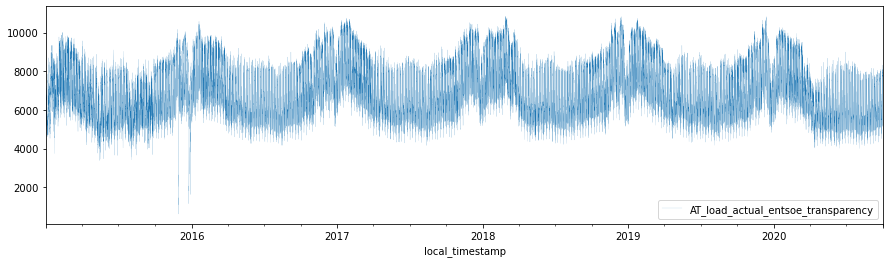

In [17]:
# Graficar serie
data.plot(x="local_timestamp", y="AT_load_actual_entsoe_transparency", figsize=(15, 4), linewidth=0.1)

In [24]:
data['local_timestamp'].dt.year

5         2015
6         2015
7         2015
8         2015
9         2015
          ... 
201598    2020
201599    2020
201600    2020
201601    2020
201602    2020
Name: local_timestamp, Length: 201598, dtype: int64

<AxesSubplot:xlabel='local_timestamp'>

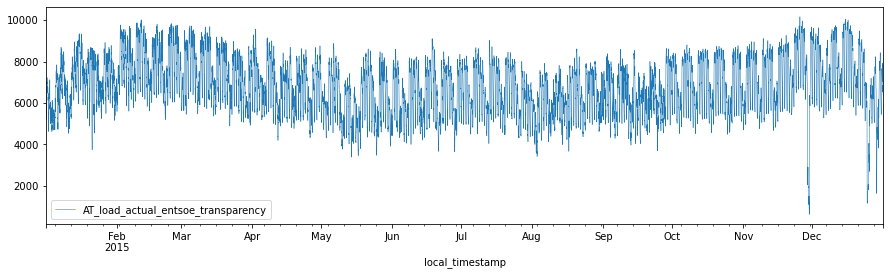

In [28]:
data[data['local_timestamp'].dt.year==2015].plot(x="local_timestamp", y="AT_load_actual_entsoe_transparency", figsize=(15, 4), linewidth=0.5)

In [18]:
4*24

96

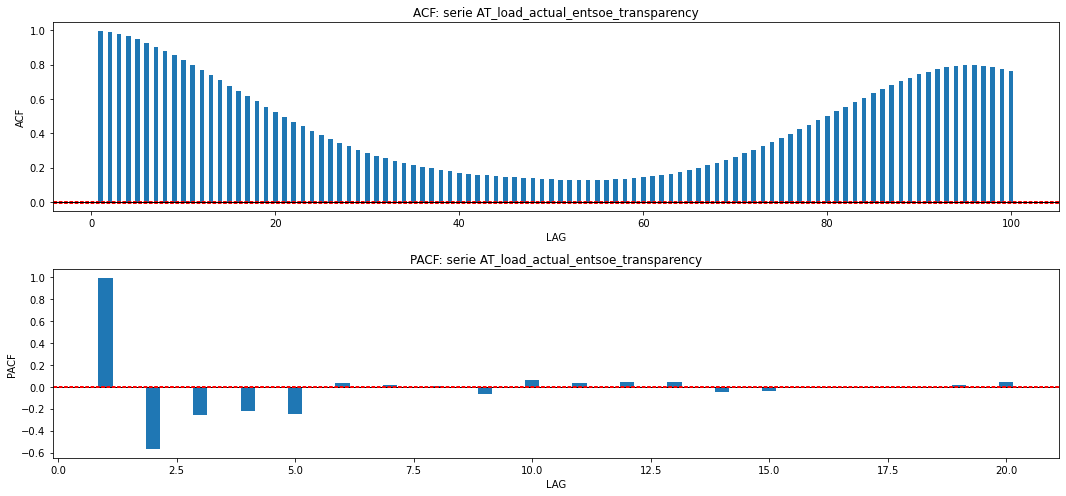

In [18]:
# ACF y PACF de la serie AT_load_actual_entsoe_transparency
fig, axes = plt.subplots(nrows=2, figsize=(15, 7))

acf1(serie, nlags=100, ax=axes[0], width=.5)
axes[0].set_title("ACF: serie AT_load_actual_entsoe_transparency")

acf1(serie, nlags=20, pacf=True, ax=axes[1], width=.3)
axes[1].set_title("PACF: serie AT_load_actual_entsoe_transparency")

fig.tight_layout()
plt.show()

In [30]:
model = sm.tsa.SARIMAX(serie, order = (1,0,0),seasonal_order=(1, 0, 0, 96), trend="c").fit() # SARIMA(1,0,0)
print(model.summary())

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


KeyboardInterrupt: 

In [ ]:
fig = model.plot_diagnostics(figsize=(10, 7))
fig.tight_layout()
plt.show()

In [20]:
import plotly.express as px

datos = data[data['local_timestamp']>=r]
px.line(datos, x='local_timestamp', y="AT_load_actual_entsoe_transparency", markers=True)

NameError: name 'r' is not defined